In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import cPickle as pickle
sys.path.insert(0,"../python/rrvf2017/")
import rrvf_model as rrvf
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Mean of models

In [2]:
def simple_mean(files):
    lst=[pd.read_csv(fname,index_col=0) for fname in files]
    df=0
    for u in lst:
        df=df+np.log1p(u)
    df=df/len(lst)
    df=np.expm1(df)
    return df

In [50]:
!ls ../submission/ -alrt |tail

-rw-rw-r--  1 bo bo  337011 Feb  5 04:33 l3_3003_conv_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259407 Feb  5 13:57 l3_3006_xgb_fold0_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259528 Feb  5 13:57 l3_3006_xgb_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259100 Feb  5 13:57 l3_3006_xgb_fold2_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259455 Feb  5 13:57 l3_3006_xgb_fold3_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259365 Feb  5 13:57 l3_3006_xgb_fold4_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337007 Feb  5 13:57 l3_3006_xgb_foldmean_False_d478.csv.gz
-rw-rw-r--  1 bo bo  337476 Feb  5 15:27 l3_3003_conv_fold3_False_d478.csv.gz
drwxrwxr-x  2 bo bo   12288 Feb  5 15:31 .
-rw-rw-r--  1 bo bo  337363 Feb  5 15:31 l3_3003_conv_fold4_False_d478.csv.gz


In [51]:
name='l3_3003_conv_fold{}_False_d478.csv.gz'  
files=['../submission/'+name.format(i) for i in range(5)]
u=simple_mean(files)

In [52]:
u.to_csv("../submission/"+ name.format('mean'),compression='gzip')

In [6]:
for v in [0.485,0.48,0.475,0.47,0.465]:
    print v, np.sqrt(1-v**2/0.65241814)

0.485 0.799660355031
0.48 0.804271252278
0.475 0.808808489759
0.47 0.813273300315
0.465 0.817666870392


# weighted 

In [7]:
from multiprocessing import Pool

In [8]:
filenames=!ls *.pkl|grep fold4
filenames=[u.replace("fold4",'fold{}') for u in filenames]
filenames

['l2_3000_ridge_fold{}_False_d478.pkl',
 'l2_3001_lgb_fold{}_False_d478.pkl',
 'l2_3003_conv_fold{}_False_d478.pkl',
 'l2_3006_xgb_fold{}_False_d478.pkl']

In [9]:
def f(fname):
    return [ pickle.load(open(fname.format(i))) for i in range(5)]

In [10]:
p = Pool(4)

In [11]:
res=p.map(f, filenames)

In [12]:
pkldata=dict(zip(filenames,res))

In [13]:
#pkldata={fname: [ pickle.load(open(fname.format(i))) for i in range(5)] for fname in filenames}

In [14]:
p.close()

In [15]:
pkldata.keys()

['l2_3000_ridge_fold{}_False_d478.pkl',
 'l2_3003_conv_fold{}_False_d478.pkl',
 'l2_3001_lgb_fold{}_False_d478.pkl',
 'l2_3006_xgb_fold{}_False_d478.pkl']

In [16]:
def get_valid_data(fname,offset,fold,return_test=False):
    validpred,testpred=pkldata[fname][fold][offset]
    validdf=pd.DataFrame({"ytrue":np.squeeze(validpred[0]),fname:np.squeeze(validpred[2])},
                         index=[tuple(u) for u in validpred[1]])
    testdf=pd.DataFrame({ fname:np.squeeze(testpred[0])},index=  testpred[1]) if return_test else None
    return validdf,testdf

In [17]:
def show_valid(fold):
    d={}
    for fname in pkldata.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=get_valid_data(fname,offset,fold)
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                #print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

l2_3000_ridge_fold{}_False_d478.pkl
l2_3003_conv_fold{}_False_d478.pkl
l2_3001_lgb_fold{}_False_d478.pkl
l2_3006_xgb_fold{}_False_d478.pkl
{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


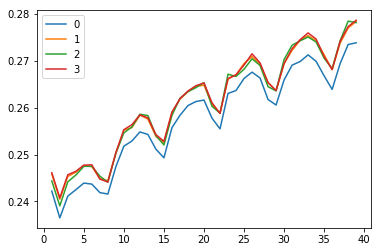

In [18]:
a=show_valid(0)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l2_3000_ridge_fold{}_False_d478.pkl
l2_3003_conv_fold{}_False_d478.pkl
l2_3001_lgb_fold{}_False_d478.pkl
l2_3006_xgb_fold{}_False_d478.pkl
{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


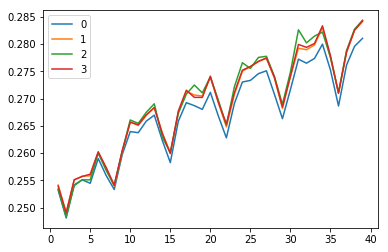

In [19]:
a=show_valid(1)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l2_3000_ridge_fold{}_False_d478.pkl
l2_3003_conv_fold{}_False_d478.pkl
l2_3001_lgb_fold{}_False_d478.pkl
l2_3006_xgb_fold{}_False_d478.pkl
{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


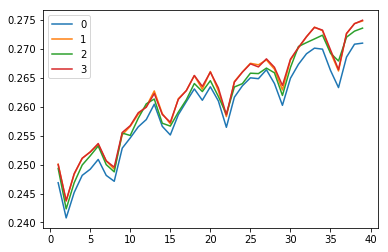

In [20]:
a=show_valid(2)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l2_3000_ridge_fold{}_False_d478.pkl
l2_3003_conv_fold{}_False_d478.pkl
l2_3001_lgb_fold{}_False_d478.pkl
l2_3006_xgb_fold{}_False_d478.pkl
{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


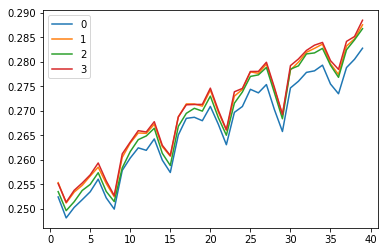

In [21]:
a=show_valid(3)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l2_3000_ridge_fold{}_False_d478.pkl
l2_3003_conv_fold{}_False_d478.pkl
l2_3001_lgb_fold{}_False_d478.pkl
l2_3006_xgb_fold{}_False_d478.pkl
{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


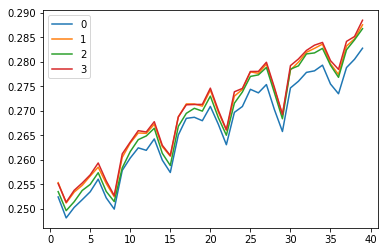

In [22]:
aa=show_valid(4)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [23]:
def get_data_wo_fold():
    d={}
    for fname in pkldata.keys():
        d[fname]={}
        for offset in range(1,40):
            lst1=[];lst2=[]
            for fold in range(5):
                validdf,testdf=get_valid_data(fname,offset,fold,return_test=True)
                lst1.append(validdf)
                lst2.append(testdf)
            validdf=pd.concat(lst1)
            testdf=pd.concat(lst2)
            if np.random.random()<0.2:
                print fname,offset,validdf.shape, validdf.dropna().shape, testdf.shape
            d[fname][offset]=[validdf.dropna(),testdf]
    return d
pkdata_wo_fold=get_data_wo_fold()

l2_3000_ridge_fold{}_False_d478.pkl 3 (216724, 2) (216724, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 10 (210384, 2) (210384, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 16 (210100, 2) (210100, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 20 (203828, 2) (203828, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 25 (200380, 2) (200380, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 29 (212972, 2) (212972, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 31 (196662, 2) (196662, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 34 (194857, 2) (194857, 2) (4145, 1)
l2_3000_ridge_fold{}_False_d478.pkl 38 (192405, 2) (192405, 2) (4145, 1)
l2_3003_conv_fold{}_False_d478.pkl 6 (245292, 2) (208763, 2) (4145, 1)
l2_3003_conv_fold{}_False_d478.pkl 8 (245292, 2) (222868, 2) (4145, 1)
l2_3003_conv_fold{}_False_d478.pkl 15 (245292, 2) (217573, 2) (4145, 1)
l2_3003_conv_fold{}_False_d478.pkl 27 (245292, 2) (194544, 2) (4145, 1)
l2_3003_conv_fold{}_False_d478.pkl 31 (245292, 2) (191922,

In [26]:
def MSE(y,ypred):
    ind= (~np.isnan(y)) & (~np.isnan(ypred))
    y=y[ind]
    ypred=ypred[ind]
    return mean_squared_error(y,ypred)
def make_l2_features_by_model(filename, pkdata_wo_fold,offset):
    lst1=[];lst2=[]
    for fold in range(5):
        validdf,testdf=get_valid_data(filename,offset,fold,return_test=True)
        lst1.append(validdf)
        lst2.append(testdf)
    valid=pd.concat(lst1)
    #print valid.columns
    y=valid['ytrue'].values
    valid=valid.drop('ytrue',axis=1)
    print filename, MSE(y,valid.iloc[:,0].values)
    test=reduce(lambda u,v: u+v,lst2)/len(lst2)
    test['idx']=test.index.map(lambda u: tuple([u,478]))
    test=test.set_index('idx')
    total=pd.concat([valid,test])
    arr=np.zeros([829,517],dtype=np.float32)*np.nan
    #print total.index
    index=total.index.map(lambda u: tuple([u[0],u[1]+offset-1]))
    arr[zip(*index)]=total.iloc[:,0].values
    return arr
def make_l2_features(pkdata_wo_fold,offset):
    cols=list(pkdata_wo_fold.keys())
    lst=[]
    for col in cols:
        arr=make_l2_features_by_model(col,pkdata_wo_fold,offset)
        lst.append(arr)
    return cols, np.array(lst)


In [27]:
for offset in range(1,40):
    print offset,
    a,b=make_l2_features( pkdata_wo_fold,offset)
    np.savez_compressed("../input/l2_prediction_offset{}.npz".format(offset),columns=a,arr=b)

1 l2_3000_ridge_fold{}_False_d478.pkl 0.247923
l2_3003_conv_fold{}_False_d478.pkl 0.249471835759
l2_3001_lgb_fold{}_False_d478.pkl 0.250603247324
l2_3006_xgb_fold{}_False_d478.pkl 0.2506
2 l2_3000_ridge_fold{}_False_d478.pkl 0.242663
l2_3003_conv_fold{}_False_d478.pkl 0.24425476972
l2_3001_lgb_fold{}_False_d478.pkl 0.245415077492
l2_3006_xgb_fold{}_False_d478.pkl 0.245543
3 l2_3000_ridge_fold{}_False_d478.pkl 0.246978
l2_3003_conv_fold{}_False_d478.pkl 0.248411452703
l2_3001_lgb_fold{}_False_d478.pkl 0.249697499161
l2_3006_xgb_fold{}_False_d478.pkl 0.249882
4 l2_3000_ridge_fold{}_False_d478.pkl 0.248363
l2_3003_conv_fold{}_False_d478.pkl 0.250247919251
l2_3001_lgb_fold{}_False_d478.pkl 0.251090475812
l2_3006_xgb_fold{}_False_d478.pkl 0.251216
5 l2_3000_ridge_fold{}_False_d478.pkl 0.249594
l2_3003_conv_fold{}_False_d478.pkl 0.251642661045
l2_3001_lgb_fold{}_False_d478.pkl 0.252428259772
l2_3006_xgb_fold{}_False_d478.pkl 0.252566
6 l2_3000_ridge_fold{}_False_d478.pkl 0.251608
l2_3003_con

In [28]:
str(a)

"['l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl']"

In [29]:
#c=make_l2_features_by_model('3001_lgb_fold{}_False_d478.pkl', pkdata_wo_fold,2)

In [30]:
def show_valid():
    d={}
    for fname in pkdata_wo_fold.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=pkdata_wo_fold[fname][offset]
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

In [31]:
aa=show_valid()
df=pd.DataFrame(aa)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

l2_3000_ridge_fold{}_False_d478.pkl
l2_3003_conv_fold{}_False_d478.pkl
l2_3001_lgb_fold{}_False_d478.pkl
l2_3006_xgb_fold{}_False_d478.pkl
{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


In [32]:
def get_valid_pred(offset):
    lst=[]
    for fname in pkdata_wo_fold:
        s=pkdata_wo_fold[fname][offset][0]
        lst.append(s)
    df=pd.concat(lst,axis=1)
    return df

In [33]:
def evaluate(offset):
    a=get_valid_pred(offset)
    a=a.dropna()
    X=a[[u for u in a.columns if u<>'ytrue']].values
    y=a['ytrue'].iloc[:,0].values
    W=rrvf.make_weights(X.T,y,np.ones_like(y))
    return dict(zip([u for u in a.columns if u<>'ytrue'],W))


In [34]:
lst={}
for offset in range(1,40):
    print offset
    lst[offset]=evaluate(offset)

1
individual loss [ 0.24605385  0.24947184  0.24922676  0.24920479]
[ 0.69176488  0.10452366  0.02173653  0.18197493] 0.245442724635
2
individual loss [ 0.2408122   0.24425477  0.2439881   0.24410666]
[ 0.70865408  0.0913531   0.05703833  0.14295449] 0.240302040528
3
individual loss [ 0.24512407  0.24841145  0.24820715  0.24838718]
[ 0.69001098  0.11748625  0.05779027  0.1347125 ] 0.244528940231
4
individual loss [ 0.24679169  0.25024792  0.24991672  0.25001821]
[ 0.70885293  0.07449457  0.02958793  0.18706456] 0.246268490941
5
individual loss [ 0.24795517  0.25164266  0.25121274  0.25134602]
[ 0.72466254  0.08993708  0.03951851  0.14588188] 0.247510868592
6
individual loss [ 0.25028362  0.25372533  0.25308465  0.25350608]
[ 0.69429682  0.08778544  0.15341063  0.06450711] 0.249740543983
7
individual loss [ 0.2476474   0.25098176  0.25027603  0.25045908]
[ 0.69520875  0.07946521  0.08696186  0.13836417] 0.247143072029
8
individual loss [ 0.24540722  0.2485895   0.24774156  0.24786425]
[

{0: 'l2_3000_ridge_fold{}_False_d478.pkl', 1: 'l2_3001_lgb_fold{}_False_d478.pkl', 2: 'l2_3003_conv_fold{}_False_d478.pkl', 3: 'l2_3006_xgb_fold{}_False_d478.pkl'}


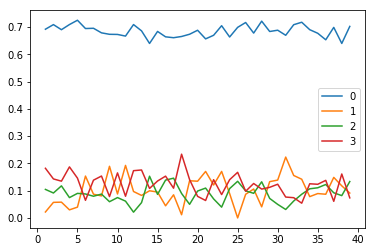

In [35]:
df=pd.DataFrame(lst).T
print dict(enumerate(df.columns))
df.columns=range(df.shape[1])
df.plot()